# Task 5

By Artem Shramko

In [1]:
import pandas as pd
import numpy as np
import sys
import itertools
import random

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import implicit 

from sklearn.metrics import auc, roc_curve, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,6]

In [2]:
# importing data, assigning row id's from the first column

data = pd.read_csv("data.csv", index_col=0)

# EDA

In [3]:
data.head()

,user_id,tutor_id
id,,
1,00000055a78bf6735c4a89358fab1de34104c3cb,e78de9dad70d230a096f0bbdc3e89b5cae04ba77
2,00000055a78bf6735c4a89358fab1de34104c3cb,b9a521730141de9bc4fe8ebc9f33713411d0101a
3,00000055a78bf6735c4a89358fab1de34104c3cb,8378136c6dd0e03be859a210a0cee03955951fb1
4,00000055a78bf6735c4a89358fab1de34104c3cb,9cc68d8345f675892bcab0fad02f65b4ac7e71ea
5,00000055a78bf6735c4a89358fab1de34104c3cb,a8272c62cd05d5b882e4f630fb55cfa0ba8491e6


In [4]:
data.describe()

,user_id,tutor_id
count,9999,9999
unique,859,1000
top,0028c76d3882ac1de97c710a5c1ec65a54174de7,e9ee460fac3c729a7de68f933621a117878dad2d
freq,185,39


That must have been a very picky yet dedicated user, if she/he has viewed 185 tutors:) 

user_id    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

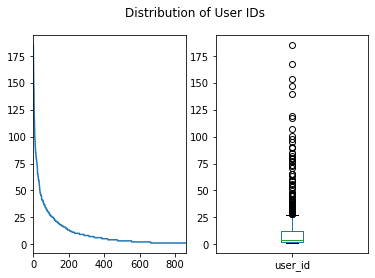

In [43]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.suptitle('Distribution of User IDs')

data.user_id.value_counts().plot(ax = axes[0], subplots=True, use_index=False)
data.user_id.value_counts().plot.box(ax = axes[1], subplots=True)


Significant outliers are present in the user_id column. In my opinion it does no seem quite plausible that regular users would be incentivised to view more than 30-50 tutors. Filtering out outliers should be further considered in the data prep part.

tutor_id    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

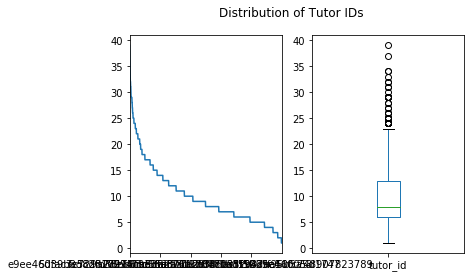

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.suptitle('Distribution of Tutor IDs')

data.tutor_id.value_counts().plot(ax = axes[0], subplots=True, ) 
data.tutor_id.value_counts().plot.box(ax = axes[1], subplots=True)

It looks like tutors and users have different ID conventions. Nevertheless, lets check if there are any tutors listed as users, since this could potentially introduce a bias.

In [7]:
users = data.user_id.unique()
tutors = data.tutor_id.unique()

tutors_as_users = [t for t in tutors if t in users]
print(tutors_as_users)

[]


Does the data contain any sequential patterns, i.e. different user sessions, 
or is it simply grouped by user IDs? Here is a fast way to check

To find out we check the difference between the index of the last and first 
member of the group by user id. If the number equals to the length of the 
group, then all the data is already grouped by user IDs. If not, then 
visits to tutors pages are split between different sessions.

In [8]:
data.groupby("user_id").apply(lambda x: (x.index[-1] - x.index[0])+1 != len(x)).sum()

0

If any of the groups had a True value, we would have a sum above 0, and this would indicate a presense of sequential pattern. 
It follows that provided data is already grouped by user ID

# A brief elaboration on the approach
In the given dataset we are supplied with only two columns, ID of a user and ID of the tutor a particular user has viewed. Since we do not have any qualitative data nor impressions, like tutor reviews, Content Based and Deep Learning based Remommender System approaches are automatically filtered out. Thus, our choice is narrowed down to the Collaborative Search algotithms. Since the data does not contain any information on time trends, sessions etc., and is simply grouped by user ID, Sequential Collaborative Search algorithms will also not be considered. 

Given type of problem is known as Collaborative Search based on Implicit Feedback. Furthermore, the task can be considered as a user-item type of problem, no disrespect meant to the tutors, of course:) Among the options to consider are the clustering approach (KNN), and the Matrix Factorisation based approaches like Alternating Least Squares, Logistic Matrix Factorisation etc.

*Note:* Sometimes tutors will be referred to as *items* as in the standardized naming convention of the user-item problem setup 

# Data Preprocessing
Since we are to work with the Collaborative Search algorithms, first step would be to generate the so called sparse user to item matrix

In [9]:
# We first hash the User and Tutor IDs in the new columns

df = data.copy() # Well actually safety first

df['user'] = df['user_id' ].apply(lambda x: np.argwhere(users  == x)[0][0])
df['tutor']= df['tutor_id'].apply(lambda x: np.argwhere(tutors == x)[0][0])

# a sparse matrix is then generated as a pivot table
user_item = df[['user','tutor']].pivot_table(index='user', columns='tutor', aggfunc=lambda x: 1, fill_value=0)

In [10]:
# Sparse matrices can get quite heavy due to high dimensionality. 
# Given sample is almost 7 MB. 

sys.getsizeof(user_item)/1000000

6.878896

In [11]:
# Common way to tackle this problem is to use Compressed Sparse Row matrix,
# which can dramatically improve performance in therms of memory usage

sparse_user_item = csr_matrix(user_item.values)

In [12]:
# An important measure for improving model performance is sparcity of data
# Ideally it should be below 90%, and it must be at least below 98.5% 

def get_sparsity(df) -> float:
    """
    Utility function to calculate sparcity of the matrix,
    i.e. what percentage if filled with zeroes
    """
    return 1.0 - np.count_nonzero(df)/df.size

In [13]:
# We should consider filtering out users with very few views to increase density of the data 

get_sparsity(user_item)

0.988359720605355

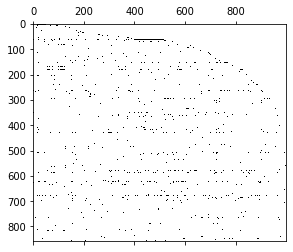

In [14]:
plt.spy(user_item)

In [15]:
def threshold_density(df, uid_min=10, uid_max=25, tid_min=5, tid_max=200):
    """
    Increases density of the data and removes outliers 
    by filtering out extreme observations
    below (above) specified min (max) values
    """
    n_users = df.user.unique().shape[0]
    n_items = df.tutor.unique().shape[0]
    density = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Before filtering')
    print('-'*16)
    print(f'# Users : {n_users}')
    print(f'# Tutors: {n_items}')
    print(f'Density : {density:4.3f}%')
    print('\n')
    
    done = False
    while not done:
        starting_shape = df.shape[0]
        tid_counts = df.groupby('user').tutor.count()
        df = df[~df.user.isin(tid_counts[tid_counts < tid_min].index.tolist())]
        df = df[~df.user.isin(tid_counts[tid_counts > tid_max].index.tolist())]
        uid_counts = df.groupby('tutor').user.count()
        df = df[~df.tutor.isin(uid_counts[uid_counts < uid_min].index.tolist())]
        df = df[~df.tutor.isin(uid_counts[uid_counts > uid_max].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True
    
    assert(df.groupby('user').tutor.count().min() >= tid_min)
    assert(df.groupby('tutor').user.count().min() >= uid_min)
    
    n_users = df.user.unique().shape[0]
    n_items = df.tutor.unique().shape[0]
    density = float(df.shape[0]) / float(n_users*n_items) * 100
    print('After filtering')
    print('-'*16)
    print(f'# Users : {n_users}')
    print(f'# Tutors: {n_items}')
    print(f'Density : {density:4.3f}%')
    return df

In [16]:
dense_df = threshold_density(df)

Before filtering
----------------
# Users : 859
# Tutors: 1000
Density : 1.164%


After filtering
----------------
# Users : 235
# Tutors: 285
Density : 6.137%


It is important to notice, that by gaining over a 5 times increase in density, we loose almost 3/4 of our data!

We can first keep it this way for prototyping, but this tradeoff must be taken into serious consideration when building models for production

## Train Test Split

The train test split for sparse data is somewhat tricky. 
Unlike the common case, where rows of data are simply transfered to the test set,
we have to hold out some interactions between user and 

In [17]:
def train_test_split(data, n_splits, fraction=None):
    """
    Split tutor data into train and test sets
    
    :Params:
    
        - data : (scipy.sparse.csr_matrix) user-item matrix 
         
        - n_splits : (int) Number of user-item-interactions per user to move
                              from training to test set.
        
        - fractions : (float) Fraction of users to split off some of their
                              interactions into test set. If None, then all
                              users are considered.
    :Returns:
        - train (scipy.sparse matrix)  matrix containing train data
        - test  (scipy.sparse matrix)  matrix containing test  data
        - user_ids (range) range of user ids for which split procedure was applied
    
    ------------------------------------------------------------------------------
    
    P.S. Use this for a reference on sparse matrix methods and datastructures: 
         https://matteding.github.io/2019/04/25/sparse-matrices/
    """
    
    # Convert Sparse Matrix to Coordinate Matrix for improved performance 
    train = data.copy().tocoo()
    # Linked Lists stores data in lil.data and indexes positions in lil.rows
    test = sparse.lil_matrix(train.shape)
    k = n_splits
    
    # In case if the fraction is specified, we search for user that fits the 
    # requirement of minimum k*2 interactions with tutors. Otherwise all
    # users are used. Using fraction allows us to use bigger datasets with
    # a less dense data
    if fraction:
        try:
            # Search for user IDs that have at least twice as many interactions
            # as the number of splits and store their IDs in a list. 
            # The train test split will be performed only on selected users
            user_ids = np.random.choice(
                np.where(np.bincount(train.row) >= n_splits * 2)[0], 
                # important! This will trigger an error is rows doest fit in
                replace=False,
                size=int(fraction * train.shape[0])
            ).tolist()
        except:
            print((f"Not enough users with > {2*k} "
                  f"interactions for fraction of {fraction} \n"))
            raise
    else:
        # If fraction is not specified, all users are used
        user_ids = range(train.shape[0])
    
    # Converting matrix to List of Lists format	
    train = train.tolil()

    # Main logic of the function
    # 1. Randomly choose k interactions in dataset
    # 2. Set their values to 0 in thain
    # 3. Set their values to 1 in test
    for user in user_ids:
        test_data = np.random.choice(data.getrow(user).indices, 
                                        size=n_splits, 
                                        replace=False)
        train[user, test_data] = 0.
        test[user, test_data] = data[user, test_data]
   
    # Check if test and train are disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_ids

In [18]:
# If we try to split the data without replacement with a fraction higher than 1, error is raised
# This is due to the fact that the data is very sparce
# Thus we only apply the split to the 30% fraction of data which has more values than the split size

train, test, test_user_ids = train_test_split(sparse_user_item, 5, 0.3)

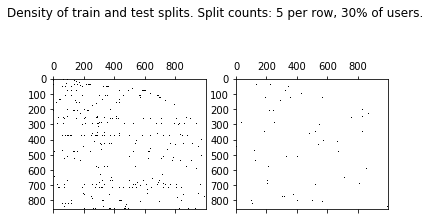

In [19]:
# Plotting the sparsity of the obtained train and test data

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Density of train and test splits. Split counts: 5 per row, 30% of users.')
ax1.spy(train.todense())
ax2.spy(test.todense())

In [20]:
def df_to_sparse_matrix(df, user_col:str = 'user_id', tutor_col:str = 'tutor_id'):
    """
    Converting a pandas dataframe to a user-to-tutor [N_users x N_tutors] sparse matrix
    Each row represents a unique user, each column a unique tutor. 
    If user has viewed a tutor -> matrix[user_id, tutor_id] = 1 
    Otherwise zero.
    
    :Params:
        - df:        (pandas.DataFrame) containing 2 columns to be transformed
        - user_col:  (str) column in df representing users (rows in sparse matrix)
        - tutor_col: (str) column in df representing tutors (columns in sparse matrix)
    :Returns:
        - user-to-tutor sparse matrix (sklearn.sparse.csr_matrix)
    """
    # Converting string values of user and tutor ids to hash values based on their position
    df['user'] = df[user_col ].apply(lambda x: np.argwhere(users  == x)[0][0])
    df['tutor']= df[tutor_col].apply(lambda x: np.argwhere(tutors == x)[0][0])
    
    # Pivot table, where each interaction between user and tutor is marked as 1
    user_tutor = df[['user','tutor']].pivot_table(index='user', columns='tutor', 
                                                  aggfunc=lambda x: 1, fill_value=0)
    
    return csr_matrix(user_tutor.values)

In [21]:
# It will be better to evaluate the model on the data with higher density
# For now we will concentrate on the filtered dataset

# Filtering df for dense observations
dense_df = threshold_density(df)

# Converting df to user-tutor matrix
d_sparse_user_tutor = df_to_sparse_matrix(dense_df)

d_train, d_test, d_test_user_ids = train_test_split(d_sparse_user_tutor, 5)

Before filtering
----------------
# Users : 859
# Tutors: 1000
Density : 1.164%


After filtering
----------------
# Users : 235
# Tutors: 285
Density : 6.137%


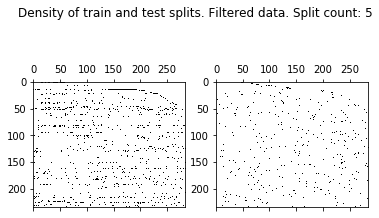

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Density of train and test splits. Filtered data. Split count: 5')
ax1.spy(d_train.todense())
ax2.spy(d_test.todense())

# Modelling

After some considerations I have decided for the Matrix Factorisation based models.

Among the options that we had, we could use either memory based or model based approach. 
The model based approach is preferred for obvious reasons. Our next decision is basically between clustering and matrix factorisation based algorithms. 
KNN is known to face a performance drop on sparse datasets, besides ever since the famous Netflix competition the focus has shifted towards other approaches, thus in this task we decide for matrix factorisation. KNN should be used as a baseline for model selection though. 

The key idea behind Matrix Factorisation is that we assume, that  the observed user to item matrix is a product of two matrices containing hidden factors, that can explain the observed interactions / user preferences. In a way, it can be observed as a contrained optimisation problem with a loss function. We can then make predictions regarding the user preferences based on the obtained hidden factor matrices by simply finding their dot product. In the obtained matrix higher predicted scores represent the higher probability of user interacting with an item.  

The Alternating Least Square (ALS) is an algorithm that helps us find those latent factors (decompose the user-item matrix). After providing a general idea of the algorithm, lets dive into code. You can find further details on the algorithm [in the original paper](http://yifanhu.net/PUB/cf.pdf) 

For this task, we will be using the python implementation of ALS from package *implicit* ([docs](https://implicit.readthedocs.io/en/latest/als.html), [github](https://github.com/benfred/implicit))


In [23]:
! export OPENBLAS_NUM_THREADS=1

In [24]:
%time

# initialize a model
d_model = implicit.als.AlternatingLeastSquares(factors=20, calculate_training_loss=True)

#d_sparse_item_user
alpha = 15

d_model.fit(d_train.T*alpha, show_progress=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [25]:
# The model has a built in method to return similar items based on the provided item ID.
# It returns a list of tuples with N recommendations and respetive scores. As you can see,
# the recommendations are ordered based on their scores (desc)

d_model.similar_items(0)

[(0, 0.05923366),
 (1, 0.044405576),
 (138, 0.040120523),
 (173, 0.035248823),
 (142, 0.033625107),
 (19, 0.03314954),
 (178, 0.03210136),
 (174, 0.030771507),
 (175, 0.030628938),
 (153, 0.030622644)]

# Evaluation
Evaluation requires certain considerations to be taken into account.
One option would be to get the predicted tutor IDs for a user and compare them with the actual click stream data. 
However, we are somewhat limited by the mechanics of the model, since it recommends a fixed amount of tutors K.
Thus, the error would ambiguous, when tested on the users, who did not visit the exact amount of tutors as the model is told to predict.
Limitig the test set to the users with number of visits equal to K will not be representative for the dataset.

The alternative and better solution would be to extract the predicted factor vectors for users and items from the model, 
find their dot product (i.e. reconstructed user-item matrix) and compare the scores to the true binary values. 
Factor vecors lay at the core of Alternating Least Squares algorithm and the same scores are used when generating K predictions.
Thus, by extracting the factors from the model we are obtaining a workaround to the obstacle desribed above.

### Measures

Since we are dealing with very sparse data, we need to take into account for high class imbalance when selecting metrics. We will use AUC (Area under the Curve) metric for both ROC (Receiver Operating Characteristics) as well as the Precision-Recall curve.

ROC basicall tells how much our recommender system is capable of distinguishing whether a user would be interested in viewing a tutor. 

But since we are dealing with a very high class imbalance (to be precise, we will need to classify 5 out of 285 tutors on filtered data correctly), the Precision-Recall curve is often preferred. It is especially usefull for the problems with a lot of 0 and few 1, since this measure is less interested in correclty specifying the negative (0) classes and is focused on the true positives, i.e. tutor views. 

Besides, we should also consider using solely the precision as well. The precision is intuitively the ability of the model not to label as positive a sample that is negative.

In [26]:
def calculate_roc_auc(y_pred, y_true) -> float:
    '''
    Area under the Receiver Operating Characterisic curve
    
    :Params:
    
    - y_pred: 1D Array of predicted values
    
    - y_true: 1D Array of true values
    
    Returns:
    
    - ROC AUC value (float)
    '''
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return auc(fpr, tpr) 

In [27]:
def calculate_pr_auc(y_pred, y_true) -> float:
    '''
    Area under the Precision-Recall curve
    
    :Params:
    
    - y_pred: 1D Array of predicted values
    
    - y_true: 1D Array of true values
    
    Returns:
    
    - Precision-Recall AUC value (float)
    '''
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision) 

In [28]:
def get_metric_scores(train, test, test_user_ids, user_factors, item_factors) -> dict:
    '''
    This function will calculate the mean AUC by user for any user 
    that had their user-item matrix altered. 
    
    :Params:
    
        - train - train dataset with some item interactions (tutor views) hidden
                       
        - test -  test dataset containing the true item interactions 
                  extracted from the train set

        - test_user_ids - ids of user for whom the train_test_split procedure 
                          was applied to 
       
       -------------------------------------------------------------------------------
        Following two parameters are the vectors containig predicted user 
        and item factors by applying the Matrix Factorisation procedure 
        on the initial user-item matrix:
        
        - user_factors - matrix [n_users   : n_factors] 
                         Array of latent factors for each item in the training set
        
        - item_factors - matrix [n_factors :   n_items] 
                         Array of latent factors for each user in the training set    
    
    :Returns:
    
        - The average ROC AUC   (float)
        - The average PR AUC    (float)
        - The average Precision (float)
        - The average MSE       (float)
        
        !Both measures are calculated only on user rows, 
         where data has been kept out for the test purposes!
    
    '''
    
    # The measures are calculated based on each user (row), which has been alternated for 
    # testing purposes.
    roc_auc_list = [] # ROC AUC values
    mse_list = [] # MSE values  
    pr_auc_list = [] # Precision-Recall AUC values
    precision_list = [] # Precision values
    
    for user in test_user_ids: # Iterate through each user that had an item altered
        
        # We look into each tow in the training set, where some of the true values
        # were removed during the train test split. 
        train_row = train[user,:].toarray().reshape(-1)
        # We also remove the items impressions that are already contained in the
        # training set, because they can bias our scores.
        # For each test row, only the items with no actions (0) are considered
        test_item_ids = np.where(train_row == 0)
        
        # Here we reconstruct the user - item sparse matrix from the factor vectors
        # The obtained values represent the likelihood of a user to interact with item,
        # i.e. view the tutor
        user_vector = user_factors[user,:]
        y_pred = user_vector.dot(item_factors).toarray()[0,test_item_ids].reshape(-1)
        
        # For the True values, we exclude the tutor views that have already been 
        # observed in the train dataset
        y_true = test[user,:].toarray()[0,test_item_ids].reshape(-1) 
        
        # Appending the measure lists. Mean value is calculated upon return
        roc_auc_list.append(calculate_roc_auc(y_pred, y_true)) 
        mse_list.append(mean_squared_error(y_pred, y_true)) 
        pr_auc = calculate_pr_auc(y_pred, y_true)
        pr_auc_list.append(pr_auc)
        precision_list.append(average_precision_score(y_true, y_pred))
    
    # Dictionary containing average scores for metrics
    scores = {"roc_auc":np.mean(roc_auc_list),
                 "pr_auc":np.mean(pr_auc_list),
                 "precision":np.mean(precision_list),
                 "mse":np.mean(mse_list)}
    
    return scores 


In [29]:
# Test evaluation function
get_metric_scores(d_train, d_test, d_test_user_ids, 
              sparse.csr_matrix(d_model.user_factors), sparse.csr_matrix(d_model.item_factors.T))

{'roc_auc': 0.7464915113100862,
 'pr_auc': 0.2288274432161773,
 'precision': 0.18871519852215066,
 'mse': 0.05605051200320876}

# Model Selection
In this section we compare three Matrix Factorisation based models:

- Alternating Least Squares
- Bayesian Personalized Ranking
- Logistic Matrix Factorization

*Note* Ideally we would start with a simple baseline model, 
for exaple a memory based Collaborative Filtering based on 
Pearson Score. We would also add a clustering model, i.e. KNN, 
for performance comparison. 

However, this would most likely require us to refactor our 
evaluation functions, which is not feasible at the moment 
due to the imposed time constraints on the task.

In [30]:
def evaluate_model(train, test, test_user_ids, model) -> dict:
    """
    Utility function for model evaluation
    
    :Params:
        - train (crs matrix)
        - test  (crs matrix)
        - test_user_ids (list / iterator)
        - model (model object) - model to be evaluated
    
    :Uses:
        - get_metric_scores() function
    :
    """
    
    model.fit(train.T*alpha, show_progress=True)

    return get_metric_scores(train, test, test_user_ids, 
                      sparse.csr_matrix(model.user_factors), 
                      sparse.csr_matrix(model.item_factors.T))
    

In [31]:
%time

als = implicit.als.AlternatingLeastSquares(factors=20)
bpr = implicit.bpr.BayesianPersonalizedRanking(factors=20)
lmf = implicit.lmf.LogisticMatrixFactorization(factors=20)

models = {"Alternating Least Squares": als,
         "Bayesian Personalized Ranking": bpr,
         "Logistic Matrix Factorization": lmf}

print("Filtering Dataset")
print("-"*30)

test_dense_df = threshold_density(df, uid_min=10, uid_max=25, tid_min=5, tid_max=200)
t_sparse_user_item = df_to_sparse_matrix(test_dense_df)

# In order to get better inference on the performance of the model, we limit 
# out test dataset to the users with 16+ views due to high sparsity of the
# data. This is acceptable when we compare models against each other, i.e.
# metric scores are evaluated relatively to each other. In order to get
# an insight on final model performance, complete dataset should be included.
train, test, test_user_ids = train_test_split(t_sparse_user_item, 8, 0.35)

print("\nEvaluating Models")
print("-"*30)

model_scores = []

for name, model in models.items():
    print(name)
    scores = evaluate_model(train, test, test_user_ids, model)
    model_scores.append(scores)

    
print("\nModel Scores")
print("-"*30)
    
pd.DataFrame(model_scores, index=["ALS", "BPR", "LMF"])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs
Filtering Dataset
------------------------------
Before filtering
----------------
# Users : 859
# Tutors: 1000
Density : 1.164%


After filtering
----------------
# Users : 235
# Tutors: 285
Density : 6.137%

Evaluating Models
------------------------------
Alternating Least Squares



Bayesian Personalized Ranking



Logistic Matrix Factorization




Model Scores
------------------------------


,mse,pr_auc,precision,roc_auc
ALS,0.092739,0.267298,0.294099,0.837933
BPR,0.436816,0.216435,0.242562,0.807299
LMF,4.238979,0.203870,0.231804,0.814196


It can be clearly seen, that Alternating Least Squares algorithm outperforms its competitors by all metrics.
The important ones for us are the Precision-Recall AUC and Precision metrics. It can goughly be interpreted as 
for 1/4th of the cases the model has correctly recommended a tutor, i.e. a user has viewed the tutor in reality. 

As described in the Evaluation section, the ROC AUC value is not very informative here. If we are to include more data
with lower number od splits (i.e. even higher class imbalance than currently), the ROC AUC will actually go up, whilst
precision and P-R AUC will drop significantly. 

The MSE measure is technically not informative here. All it says is that the scores in the predicted factorised matrix 
values have a higher range for LMF and BPR models compared to ALS, which is due to the mechanics of the algirithm. 

We will procede further on with the Alternating Least Squares algorithm. 

# Model Tuning

I am not going to implement this part due to the time constraints, since grind search procedure can be quite time consuming.

But I believe it is important to mention the steps that I would otherwise take.

If we look into the documentation [link](https://implicit.readthedocs.io/en/latest/als.html), several model parameters grab our attention right away: 

- factors (int, optional) – The number of latent factors to compute
- regularization (float, optional) – The regularization factor to use
- iterations (int, optional) – The number of ALS iterations to use when fitting data

It would be optimal to get acquainted with the original paper on the algorithm to get a better undertanding of how those settings can affect the model.

Then I would look up some papers on model benchmarking for implicit feedback collaborative search to get the idea of the ranges for those parameters (and maybe get inspired to try out some additional models for the previous step). 

The grid search algorithm would be an iterator over possible combinations of params within the specified ranges, that would store learning curves for each model parametrisation. 
In the end, the best performing combination would be selected



# Making Predictions

In [32]:
# Since we will be further working with sparse matrices, 
# we should consider a convenient way of converting the obtained hashed IDs
# into their original values

class Mapper:
    """
    Maps tutor and user IDs to their hashed values.
    Useful for converting model output into original IDs.
    
    :Params:
       - df:            (pandas obj) Dataset
       - user_col:      (str)        Name of the user column with IDs
       - tutor_col:     (str)        Name of the tutor column with IDs
        
    :Methods:
       - get_tutor_id   (public)     Converts given id into its hashed form
                                    and vice versa
       - get_user_id    (public)     -//-
        
       - _map_tutor_ids (protected)  maps tutor IDs to hash values
       - _map_user_ids  (protected)  maps user IDs to hash values
    """
    
    def __init__(self, df, user_col:str, tutor_col:str):
        
        self._tid_to_idx = {} # tutor id to hash
        self._idx_to_tid = {} # hash to tutor id
        self._uid_to_idx = {} # user id to hash
        self._idx_to_uid = {} # hash to user id
        
        self._map_tutor_ids(df, tutor_col)
        self._map_user_ids(df, user_col)
    
    def _map_tutor_ids(self, df, tutor_id:str):
        """
        Maps tutor IDs from the dataset
        to their hashed values
        """
        
        for (idx, tid) in enumerate(df[tutor_id].unique().tolist()):
            self._tid_to_idx[tid] = idx
            self._idx_to_tid[idx] = tid
            
    def _map_user_ids(self, df, user_id:str):
        """
        Maps user IDs from the dataset
        to their hashed values
        """

        for (idx, uid) in enumerate(df[user_id].unique().tolist()):
            self._uid_to_idx[uid] = idx
            self._idx_to_uid[idx] = uid
            
    def get_tutor_id(self, index):
        """
        Getter for tutor IDs
        
        :Params:
            - index (str / int) - ID either original or hashed
            
        :Returns:
            - ID    (int / str) - converted value of the ID
        """
        if type(index)==str:
            return self._tid_to_idx[index]
        elif type(index)==int:
            return self._idx_to_tid[index]
        else:
            print("False format. Accepts types <str>, <id>")
            
    def get_user_id(self, index):
        """
        Getter for user IDs
        
        :Params:
            - index (str / int) - ID either original or hashed
            
        :Returns:
            - ID    (int / str) - converted value of the ID
        """
        if type(index)==str:
            return self._uid_to_idx[index]
        elif type(index)==int:
            return self._idx_to_uid[index]
        else:
            print("False format. Accepts types <str>, <id>")

In [33]:
# Initialising mapper 

mapper = Mapper(test_dense_df, "user_id", "tutor_id")

In [34]:
# In order to get recommendation of similar tutors, we use
# a built in method "similar_items"

def recommend_tutors(tutor_id:str, model, mapper) -> list:
    """
    Returns recommendation of similar tutors
    based on the provided tutor ID
    
    :Params:
        - tutor_id: (str) Tutor ID to recommend upon
        - model:    (implicit) Fitted model instance
        - mapper:   (Mapper) Instance of Mapper containing
                             ID to hash mappings
                            
    :Returns:
        List of tutor ID strings
    """
    idx = mapper.get_tutor_id(tutor_id)
    pred_idx = model.similar_items(idx, 11)[1:]
    tutors = [mapper.get_tutor_id(int(i[0])) for i in pred_idx]
    return tutors

In [36]:
# Getting tutor recommendations 

recommends = recommend_tutors("ff0d3fb21c00bc33f71187a2beec389e9eff5332", als, mapper)

for i, idx in enumerate(recommends):
    print(i+1, idx)
    


1 4c10212fc75188623bf4c5078efd097f413bbd96
2 df98e222a23a2bcb2fafa499fc1c8031a4a06c9c
3 14715d496870085e541fe19a01e8f7e5d6bca588
4 cd5c1243ab213d8b4fd91aa1d4258ec10d9dc911
5 08987c582becc348d288efcc9cd7477b6524a3c2
6 0cbb51f1f43646c1718553da0c5864d4e1a6f037
7 fed8505b88adf6d879b4df147b29a068d98faa72
8 654fcb963c0fff776c8295e828c243fa67eb5671
9 7df31bf2dc2dd9651c09488e6abdc1cd83215ae2
10 7d99897dd53f5345c6b69d2b3611627f324c8e2f


# Summary

In this notebook we have built a Collaborative Search based recommendation system for implicit feedback dataset of user and tutor interactions. 
The Matrix Factosiation based Alternating Least Squares model was selected based on its performance (P-R AUC, ROC AUC, Precision) amongst the other 
(MF based) models.

There are several challanges present in the data that had to be mitigated:

- Outliers - users with an unplausibly high amount of interactions have been filtered out
- High sparsity - density of the dataset was improved by applying a filtering function that allows to select only those users and tutors who pass certain frequency threshold 
- High class imbalance - choose metrics wisely. Precision-Recall curve AUC has proven to be more informative over ROC AUC, because it focuses on the underrepresented class of positive values (interactions between users and tutors)

Steps to be done to improve the model in the given setup:

- Better (broader) benchmarking - we have compared 3 matrix factorisation based models due to time constraints. Alternative approaches should be included + Knn as a baseline
- Model tuning - grid search procedure should be applied to find optimal parameters of the best perorming model(s)
- Ensemble learning - an interesting thing to try would be combining predictions from several algorithms and making recommendations based on (wighted) majority votes

In the end, the presented model serves its purpose and delivers N recommendations given a tutor id